# Restrict the SDN analysis to non-bordering squares.

The reviewers have suggested us to look at the difference between Divisive Normalization parameter gamma by removing the non-neighbouring squares from the analysis and rechecking the sublnearity. Here we compare values of $\gamma$ before and after removing the coordinates which had neighbouring squares in the photostimulation coordinates. We see no major difference in $\gamma$ before and after removing these coordinates.

In [2]:
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
from pickle import dump
import lmfit
import numpy as np
import scipy.stats as ss
plt.style.use('neuron')
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')
from Linearity import Neuron
from matplotlib import  rc
from matplotlib.ticker import NullFormatter
from numpy import mean, sqrt, square, arange
from itertools import combinations
rc('text', usetex=False)

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
def simpleaxis(axes, every=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [4]:
def hasNonBorderingSquares(coord):
    ''' Pick up n-square coordinates which don't have neighbouring squares '''
    neighbourList = []
    for xy in coord:
        x,y =xy
        neighbourList+= [(x-1, y-1), (x-1, y), (x-1, y+1), (x,y-1), (x, y+1), (x+1, y-1), (x+1, y), (x+1, y+1)]

    neighbourSet = set(neighbourList)

    for xy in coord:
        x,y = xy
        coordSet = set([(x,y)])
        if coordSet.issubset(neighbourSet):
            return False
    return True

In [5]:
prefix = '/home/bhalla/Documents/Codes/data'
#prefix = ''
currentClampFiles = prefix + '/media/sahil/NCBS_Shares_BGStim/patch_data/normalization_files.txt'
with open (currentClampFiles,'r') as r:
    dirnames = r.read().splitlines()

In [6]:
neurons = {}

for dirname in dirnames:
    cellIndex = dirname.split('/')[-2]
    filename = prefix + dirname + 'plots/' + cellIndex + '.pkl'
    n = Neuron.load(filename)
    if n:
        neurons[str(n.date) + '_' + str(n.index)] = n

/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/2_c1_150828/plots/2_c1_150828.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/3_c1_150929/plots/3_c1_150929.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/1_c4_150827/plots/1_c4_150827.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/Control_RS_short/6_c2_160513/plots/6_c2_160513.pkl not found.
/home/bhalla/Documents/Codes/data/media/sahil/NCBS_Shares_BGStim/patch_data/RS_Analysis/Patch_Recording/RS_TBS_short/5_c4_160122/plots/5_c4_160122.pkl not found.


In [7]:
#Colorscheme for squares
color_sqr = { index+1: color for index, color in enumerate(matplotlib.cm.viridis(np.linspace(0,1,9)))}
#Colorscheme for cells
color_cell = matplotlib.cm.plasma(np.linspace(0,1,len(dirnames)))

In [10]:
def findThreshold(trace, thresVal=0.1):
    ''' This returns the action potential threshold '''
    peakIndex = np.argmax(trace)
    slope = np.diff(trace[:peakIndex])
    maxSlope = np.max(slope)
#     print("values are ", np.where(slope>thresVal*maxSlope)[0])
    threshold = trace[np.where(slope>thresVal*maxSlope)[0][0]]
    return threshold

In [24]:
def linearModel(x, beta=100):
    # Linear model
    return (x*(1-beta))

def DN_model(x, alpha=1, beta=1, gamma=1):
    # Divisive normalization modelg
    #return x - a*(x**2)/(b+x)
    #return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)
    return (gamma*x)/(x+gamma)
    
#     exc = 65
#     A = 1 - np.exp(-x/alpha)
#     B = beta*(1 - np.exp(-x/alpha))
# #     A = beta*(np.exp(x-alpha)-1)
# #     B = gamma*(np.exp(x-alpha)-1)
# #     A = (1 + np.tanh(x - alpha))/2
# #     B = np.abs(beta)*(1 + np.tanh((x - alpha)))/2
#     G = exc/(B-A-A*B)
#     return x/((x/G) + 1)
    
    #return (gamma*x *(1 + np.exp(-alpha*x)))/(x+gamma)
    #B = (1 + np.tanh((x - alpha)))/2
    #np.exp((1-alpha)*x)
    #B = beta * (np.exp(x)-1)
    #return (gamma*x + alpha*np.tanh(-x) - beta*(1-alpha*np.tanh(-x)))/(1 + gamma*x)
    #return (beta*x *(1 + (alpha*np.tanh(x))))/(x *(beta*alpha*np.tanh(x) + beta - 1) + 1)

## Normal measurement of SDN parameter $\gamma$

In [25]:
feature = 0 # Area under the curve
lin_bic = []
dn_bic = []
lin_chi = []
dn_chi = []
beta = []
gamma = []
delta = []
zeta, zeta2 = [], []
AP_thres = {}
g_AP_thres = {}
gamma_DN = {}

for index in neurons:
    print (index)
    neuron = neurons[index]
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            ap_list = []
            for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                observed[sqr].append(trial.feature[feature])
                            elif trial.flags['AP_flag'] == 1:
#                                 print ("trial had AP", index, trial.index)
#                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                ap_list.append(trial.baseline +  findThreshold(trial.interestWindow))
            if ap_list:
                AP_thres[index] = np.mean(ap_list)
            else:
                AP_thres[index] = np.nan
            max_exp, max_g_exp = 0.,0.

            squareVal = []
            list_control_expected = []
            list_control_observed = []

            for sqr in sorted(observed):
#                 squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
                max_exp = max(max_exp, max(expected[sqr]))
                list_control_expected += expected[sqr]
                list_control_observed += observed[sqr]

            X = np.array(list_control_expected)
            y = np.array(list_control_observed)
            idx   = np.argsort(X)
            X = X[idx]
            y = y[idx]

            linear_Model = lmfit.Model(linearModel)
            DN_Model = lmfit.Model(DN_model)

            lin_pars = linear_Model.make_params()
            lin_result = linear_Model.fit(y, lin_pars, x=X)
            lin_bic.append(lin_result.bic)
            lin_chi.append(lin_result.redchi)
            beta.append(lin_result.params['beta'])

            DN_pars = DN_Model.make_params()
#             print (y,X,DN_pars)
            
            try:
                DN_result = DN_Model.fit(y, DN_pars, x=X)
            except:
                print(y,X)
            dn_bic.append(DN_result.bic)
            dn_chi.append(DN_result.redchi)
            gamma.append(DN_result.params['gamma'])
            delta.append(DN_result.params['beta'])
        gamma_DN[index] = DN_result.params['gamma'].value
        if(expType == "GABAzine"):
            ap_list = []
            for sqr in exp:
                if sqr > 1:
#                     expected[sqr] = []
#                     observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        for trial in exp[sqr].coordwise[coord].trials:
                            if all([value == 0 for value in trial.flags.values()]):
                                pass
#                                 expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
#                                 observed[sqr].append(trial.feature[feature])
                            elif trial.flags['AP_flag'] == 1:
#                                 print ("trial had AP", index, trial.index)
#                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                ap_list.append(trial.baseline + findThreshold(trial.interestWindow))
#             if ap_list:
#                 AP_thres.append(np.mean(ap_list))
#             else:
#                 AP_thres.append(np.nan)
                
            if ap_list:
                g_AP_thres[index] = np.mean(ap_list)
            else:
                g_AP_thres[index] = np.nan

#             max_exp, max_g_exp = 0.,0.

#             squareVal = []
#             list_control_expected = []
#             list_control_observed = []

#             for sqr in sorted(observed):
#                 squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
#                 max_exp = max(max_exp, max(expected[sqr]))
#                 list_control_expected += expected[sqr]
#                 list_control_observed += observed[sqr]

#             X = np.array(list_control_expected)
#             y = np.array(list_control_observed)
#             idx   = np.argsort(X)
#             X = X[idx]
#             y = y[idx]

#             linear_Model = lmfit.Model(linearModel)
#             DN_Model = lmfit.Model(DN_model)

#             lin_pars = linear_Model.make_params()
#             lin_result = linear_Model.fit(y, lin_pars, x=X)
#             lin_bic.append(lin_result.bic)
#             lin_chi.append(lin_result.redchi)
#             beta.append(lin_result.params['beta'])

#             DN_pars = DN_Model.make_params()
# #             print (y,X,DN_pars)
            
#             try:
#                 DN_result = DN_Model.fit(y, DN_pars, x=X)
#             except:
#                 print(y,X)
#             dn_bic.append(DN_result.bic)
#             dn_chi.append(DN_result.redchi)
#             gamma.append(DN_result.params['gamma'])
#             delta.append(DN_result.params['beta'])
#             print (np.mean(ap_list))

170317_c1
170317_c4
161027_c3
160223_c3
160223_c2
161228_c1
160830_c1
160219_c5
170303_c1
161117_c1
170208_c3
160209_c4
160920_c1
161013_c1
160927_c5
150904_c1
170104_c4
170220_c1
170222_c2
160817_c2
150828_c2
160928_c3
160617_c5
150902_c1
150902_c2
161109_c3
160513_c5


## Measurement of SDN parameter $\gamma$ with coordinates having only non-bordering squares.

In [27]:
feature = 0 # Area under the curve
lin_bic = []
dn_bic = []
lin_chi = []
dn_chi = []
beta = []
gamma = []
delta = []
zeta, zeta2 = [], []
AP_thres = {}
g_AP_thres = {}
gamma_DN_nonNeighbour = {}

for index in neurons:
    print (index)
    neuron = neurons[index]
    expected, observed, g_expected, g_observed = {}, {}, {}, {}
    for expType, exp in neuron:
        ## Control case
        if(expType == "Control"):
            ap_list = []
            for sqr in exp:
                if sqr > 1:
                    expected[sqr] = []
                    observed[sqr] = []
                    for coord in exp[sqr].coordwise:
                        if not hasNonBorderingSquares(coord):
                            for trial in exp[sqr].coordwise[coord].trials:
                                if all([value == 0 for value in trial.flags.values()]):
                                    expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
                                    observed[sqr].append(trial.feature[feature])
                                elif trial.flags['AP_flag'] == 1:
    #                                 print ("trial had AP", index, trial.index)
    #                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                    ap_list.append(trial.baseline +  findThreshold(trial.interestWindow))
            if ap_list:
                AP_thres[index] = np.mean(ap_list)
            else:
                AP_thres[index] = np.nan
            max_exp, max_g_exp = 0.,0.

            squareVal = []
            list_control_expected = []
            list_control_observed = []

            for sqr in sorted(observed):
#                 squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
#                 max_exp = max(max_exp, max(expected[sqr]))
                list_control_expected += expected[sqr]
                list_control_observed += observed[sqr]
            
            if len(list_control_expected) and len(list_control_observed):
                X = np.array(list_control_expected)
                y = np.array(list_control_observed)
                idx   = np.argsort(X)
                X = X[idx]
                y = y[idx]

                linear_Model = lmfit.Model(linearModel)
                DN_Model = lmfit.Model(DN_model)

                lin_pars = linear_Model.make_params()
                lin_result = linear_Model.fit(y, lin_pars, x=X)
                lin_bic.append(lin_result.bic)
                lin_chi.append(lin_result.redchi)
                beta.append(lin_result.params['beta'])

                DN_pars = DN_Model.make_params()
    #             print (y,X,DN_pars)

                try:
                    DN_result = DN_Model.fit(y, DN_pars, x=X)
                except:
                    print(y,X)
                dn_bic.append(DN_result.bic)
                dn_chi.append(DN_result.redchi)
                gamma.append(DN_result.params['gamma'])
                delta.append(DN_result.params['beta'])
            gamma_DN_nonNeighbour[index] = DN_result.params['gamma'].value
            if(expType == "GABAzine"):
                ap_list = []
                for sqr in exp:
                    if sqr > 1:
    #                     expected[sqr] = []
    #                     observed[sqr] = []
                        for coord in exp[sqr].coordwise:
                            for trial in exp[sqr].coordwise[coord].trials:
                                if all([value == 0 for value in trial.flags.values()]):
                                    pass
    #                                 expected[sqr].append(exp[sqr].coordwise[coord].expected_feature[feature])
    #                                 observed[sqr].append(trial.feature[feature])
                                elif trial.flags['AP_flag'] == 1:
    #                                 print ("trial had AP", index, trial.index)
    #                                 print (trial.baseline, findThreshold(trial.interestWindow))
                                    ap_list.append(trial.baseline + findThreshold(trial.interestWindow))
    #             if ap_list:
    #                 AP_thres.append(np.mean(ap_list))
    #             else:
    #                 AP_thres.append(np.nan)

                if ap_list:
                    g_AP_thres[index] = np.mean(ap_list)
                else:
                    g_AP_thres[index] = np.nan

    #             max_exp, max_g_exp = 0.,0.

    #             squareVal = []
    #             list_control_expected = []
    #             list_control_observed = []

    #             for sqr in sorted(observed):
    #                 squareVal.append(ax.scatter(expected[sqr], observed[sqr], label=str(sqr), c=color_sqr[sqr], alpha=0.8))
    #                 max_exp = max(max_exp, max(expected[sqr]))
    #                 list_control_expected += expected[sqr]
    #                 list_control_observed += observed[sqr]

    #             X = np.array(list_control_expected)
    #             y = np.array(list_control_observed)
    #             idx   = np.argsort(X)
    #             X = X[idx]
    #             y = y[idx]

    #             linear_Model = lmfit.Model(linearModel)
    #             DN_Model = lmfit.Model(DN_model)

    #             lin_pars = linear_Model.make_params()
    #             lin_result = linear_Model.fit(y, lin_pars, x=X)
    #             lin_bic.append(lin_result.bic)
    #             lin_chi.append(lin_result.redchi)
    #             beta.append(lin_result.params['beta'])

    #             DN_pars = DN_Model.make_params()
    # #             print (y,X,DN_pars)

    #             try:
    #                 DN_result = DN_Model.fit(y, DN_pars, x=X)
    #             except:
    #                 print(y,X)
    #             dn_bic.append(DN_result.bic)
    #             dn_chi.append(DN_result.redchi)
    #             gamma.append(DN_result.params['gamma'])
    #             delta.append(DN_result.params['beta'])
    #             print (np.mean(ap_list))

170317_c1
170317_c4
161027_c3
160223_c3
160223_c2
161228_c1
160830_c1
160219_c5
170303_c1
161117_c1
170208_c3
160209_c4
160920_c1
161013_c1
160927_c5
150904_c1
170104_c4
170220_c1
170222_c2
160817_c2
150828_c2
160928_c3
160617_c5
150902_c1
150902_c2
161109_c3
160513_c5


## Plots below show that no differences are seen between the two cases.

### One outlier at 60 removed to show trend below

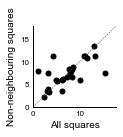

In [38]:
fig, ax = plt.subplots()
for key in gamma_DN.keys():
    ax.plot(gamma_DN[key], gamma_DN_nonNeighbour[key], '.')
ax.set_xlim(0,18)
ax.set_ylim(0,18)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("All squares")
ax.set_ylabel("Non-neighbouring squares")
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
plt.show()

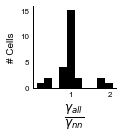

In [56]:
ratio_gamma = []
for key in gamma_DN.keys():
    ratio_gamma.append(gamma_DN[key]/gamma_DN_nonNeighbour[key])

fig, ax = plt.subplots()
ax.hist(ratio_gamma)
# ax.set_xlim(0,18)
ax.set_xlabel("$\\frac{\gamma_{all}}{\gamma_{nn}}$", fontsize='xx-large')
ax.set_ylabel("# Cells")
# ax.set_ylabel("Non-neighbouring squares")
simpleaxis(ax)
fig.set_figwidth(1.5)
fig.set_figheight(1.5)
plt.show()